# Setup


In [2]:
%pip install control
%pip install shapely

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import skfuzzy as fuzz


def gerar_tabela_verdade(fuzzy_sim, e, delta_e, delta_u):
    # Gerando todas as combinações de entradas e calculando as saídas
    results = []
    for e_val in e.terms:
        row = []
        for delta_e_val in delta_e.terms:
            fuzzy_sim.input["e"] = e_val
            fuzzy_sim.input["delta_e"] = delta_e_val
            fuzzy_sim.compute()
            delta_u_val = fuzzy_sim.output["delta_u"]

            # Convertendo o valor de saída para o rótulo correspondente
            membership_values = {}
            for label in delta_u.terms:
                membership_values[label] = fuzz.interp_membership(delta_u.universe, delta_u[label].mf, delta_u_val)
            label = max(membership_values, key=membership_values.get)
            row.append(label)
        results.append(row)

    # Criando um DataFrame com os resultados
    columns = delta_e.terms.keys()
    index = e.terms.keys()
    df = pd.DataFrame(results, columns=columns, index=index)

    # Adicionando a coluna de índice como "e[k] / Δe[k]"
    df.columns.name = "e[k] / Δe[k]"

    return df

In [4]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# Definição dos parâmetros do motor
Pmec = 95 * 10**3
n = 0.913
Vn = 400
Wn = 1890 * pi / 30
Ra = 0.08
J = 0.56
La = 1.4 * 10**-3

Pele = Pmec / n
Cmn = Pmec / Wn
Ian = Pele / Vn
Kf = (Vn - Ian * Ra) / Wn
B = (Kf * Ian - Cmn) / Wn
Tm = J / B
Te = La / Ra
T = Te / 10

# Definição das matrizes A, B e C
A = np.array([[1 - T / Te, -Kf * T / La], [Kf * T / J, 1 - T / Tm]])
B = np.array([[T / La, 0], [0, -T / J]])


def simular_resposta_fuzzy(fuzzy_sim, setpoint, K, com_delta_e=True, plot=True):
    # Definição de parâmetros
    x = np.zeros((2, 1))
    u = np.zeros((2, 1))
    N = int(5 / T)

    W, Ia, t = [0] * (N + 1), [0] * (N + 1), np.linspace(0, 5, N + 1).tolist()
    errors, delta_errors, signals = [0] * (N + 1), [0] * (N + 1), [0] * (N + 1)

    Kp, Ki = K

    for i in range(N):
        # Cálculo do erro
        curr_error = (setpoint - W[i]) / setpoint * 100
        errors[i] = curr_error

        # Entrada do controlador fuzzy
        fuzzy_sim.input["e"] = curr_error * Ki

        if com_delta_e:
            delta_errors[i] = errors[i - 1] - curr_error if i > 0 else 0
            fuzzy_sim.input["delta_e"] = delta_errors[i] * Kp

        # Processa controle fuzzy
        fuzzy_sim.compute()

        # Sinal de controle
        control_signal_current = min(400, signals[i] + fuzzy_sim.output["delta_u"])
        signals[i + 1] = control_signal_current

        # Atualiza entrada do sistema
        u[0, 0] = control_signal_current

        # Cálculo da saída
        x = A @ x + B @ u
        Ia[i + 1], W[i + 1] = x.flatten()

    if plot == False:
        return W, t, signals, errors

    # Mostrando os gráficos de velocidade, corrente, erros e sinais em uma matriz 2x2
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

    # Gráfico de Velocidade
    ax1.axhline(setpoint, color="b", linestyle="--", label="Setpoint")
    ax1.plot(t, W, color="r")
    ax1.set_title("Velocidade do eixo")
    ax1.set_xlabel("Tempo (s)")
    ax1.set_ylabel("Velocidade (rad/s)")
    ax1.set_yticks(np.arange(min(W), max(W) + 20, 15))
    ax1.tick_params(axis="y", labelsize=8)
    ax1.legend(["Velocidade"])

    # Gráfico de Sinais de Controle
    ax2.plot(t, signals, color="m")
    ax2.set_title("Sinais de Controle")
    ax2.set_xlabel("Tempo (s)")
    ax2.set_ylabel("Sinal de Controle")
    ax2.legend(["Sinal de Controle"])

    # Gráfico de Erros
    ax3.plot(t, errors, color="g")
    ax3.set_title("Erros")
    ax3.set_xlabel("Tempo (s)")
    ax3.set_ylabel("Erro")
    ax3.legend(["Erro"])

    # Gráfico de Delta Erros
    if not com_delta_e:
        delta_errors = np.zeros_like(t)
    ax4.plot(t, delta_errors, color="c")
    ax4.set_title("Delta Erros")
    ax4.set_xlabel("Tempo (s)")
    ax4.set_ylabel("Delta Erro")
    ax4.legend(["Delta Erro"])

    plt.tight_layout()
    plt.show()

    return W, t, signals, errors

# Controle PI tradicional


In [ ]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling time
T = 0.00175

# Define the transfer functions
num_gpz = [0.0058540, 0, 0]
den_gpz = [1, -1.9224928, 0.9337476]

gpz = ct.TransferFunction(num_gpz, den_gpz, T)
gpi = 0.15 * ct.TransferFunction([1, -0.95], [1, -1], T)
# gpid = 1 * ctrl.TransferFunction([1, -0.2], [1, -0.1], T)

# Compute the closed-loop transfer function
sys_open_loop = ct.series(gpz, gpi)  # C(s) * G(s)
sys_closed_loop = ct.feedback(sys_open_loop, 1)

# Root locus plot
# Simulate system response to a 400V input and 0 load
time = np.arange(0, 5, T)
T_out, yout = ct.forced_response(sys_closed_loop, T=time, U=np.ones_like(time) * 300)

# Plot the response
plt.figure()
plt.plot(T_out, yout)
plt.xlabel("Tempo (s)")
plt.ylabel("Rad/s")
plt.title("Resposta do sistema ao setpoint 200 rad/s")
plt.grid()
plt.show()

# Controle PI Fuzzy


In [ ]:
import numpy as np
from skfuzzy import control as ctrl

# Definindo as variáveis fuzzy
e = ctrl.Antecedent(np.arange(-100, 100, 0.005), "e")
delta_e = ctrl.Antecedent(np.arange(-10, 10, 0.001), "delta_e")
delta_u = ctrl.Consequent(np.arange(-10, 10, 0.001), "delta_u")

# Definindo as funções de pertinência

CODIGOS = ["NG", "NM", "NP", "ZE", "PP", "PM", "PG"]

e.automf(names=CODIGOS)
delta_e.automf(names=CODIGOS)
delta_u.automf(names=CODIGOS)

# Criando as regras fuzzy
rules_1 = [
    ctrl.Rule(e["NG"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["NM"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["NP"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["ZE"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["PP"], delta_u["NM"]),
    ctrl.Rule(e["NG"] & delta_e["PM"], delta_u["NP"]),
    ctrl.Rule(e["NG"] & delta_e["PG"], delta_u["ZE"]),
    ctrl.Rule(e["NM"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["NM"] & delta_e["NM"], delta_u["NG"]),
    ctrl.Rule(e["NM"] & delta_e["NP"], delta_u["NG"]),
    ctrl.Rule(e["NM"] & delta_e["ZE"], delta_u["NM"]),
    ctrl.Rule(e["NM"] & delta_e["PP"], delta_u["NP"]),
    ctrl.Rule(e["NM"] & delta_e["PM"], delta_u["ZE"]),
    ctrl.Rule(e["NM"] & delta_e["PG"], delta_u["PP"]),
    ctrl.Rule(e["NP"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["NP"] & delta_e["NM"], delta_u["NG"]),
    ctrl.Rule(e["NP"] & delta_e["NP"], delta_u["NM"]),
    ctrl.Rule(e["NP"] & delta_e["ZE"], delta_u["NP"]),
    ctrl.Rule(e["NP"] & delta_e["PP"], delta_u["ZE"]),
    ctrl.Rule(e["NP"] & delta_e["PM"], delta_u["PP"]),
    ctrl.Rule(e["NP"] & delta_e["PG"], delta_u["PM"]),
    ctrl.Rule(e["ZE"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["ZE"] & delta_e["NM"], delta_u["NM"]),
    ctrl.Rule(e["ZE"] & delta_e["NP"], delta_u["NP"]),
    ctrl.Rule(e["ZE"] & delta_e["ZE"], delta_u["ZE"]),
    ctrl.Rule(e["ZE"] & delta_e["PP"], delta_u["PP"]),
    ctrl.Rule(e["ZE"] & delta_e["PM"], delta_u["PM"]),
    ctrl.Rule(e["ZE"] & delta_e["PG"], delta_u["PG"]),
    ctrl.Rule(e["PP"] & delta_e["NG"], delta_u["NM"]),
    ctrl.Rule(e["PP"] & delta_e["NM"], delta_u["NP"]),
    ctrl.Rule(e["PP"] & delta_e["NP"], delta_u["ZE"]),
    ctrl.Rule(e["PP"] & delta_e["ZE"], delta_u["PP"]),
    ctrl.Rule(e["PP"] & delta_e["PP"], delta_u["PM"]),
    ctrl.Rule(e["PP"] & delta_e["PM"], delta_u["PG"]),
    ctrl.Rule(e["PP"] & delta_e["PG"], delta_u["PG"]),
    ctrl.Rule(e["PM"] & delta_e["NG"], delta_u["NP"]),
    ctrl.Rule(e["PM"] & delta_e["NM"], delta_u["ZE"]),
    ctrl.Rule(e["PM"] & delta_e["NP"], delta_u["PP"]),
    ctrl.Rule(e["PM"] & delta_e["ZE"], delta_u["PM"]),
    ctrl.Rule(e["PM"] & delta_e["PP"], delta_u["PG"]),
    ctrl.Rule(e["PM"] & delta_e["PM"], delta_u["PG"]),
    ctrl.Rule(e["PM"] & delta_e["PG"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["NG"], delta_u["ZE"]),
    ctrl.Rule(e["PG"] & delta_e["NM"], delta_u["PP"]),
    ctrl.Rule(e["PG"] & delta_e["NP"], delta_u["PM"]),
    ctrl.Rule(e["PG"] & delta_e["ZE"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["PP"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["PM"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["PG"], delta_u["PG"]),
]

# Criando o sistema de controle
control_system = ctrl.ControlSystem(rules_1)

# Simulando o sistema
fuzzy_sim = ctrl.ControlSystemSimulation(control_system)

gerar_tabela_verdade(fuzzy_sim, e, delta_e, delta_u)

e.view()
delta_e.view()

In [ ]:
W, t, signals, errors = simular_resposta_fuzzy(fuzzy_sim, 100, [0.2, 0.1])

# Teste


In [155]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from skfuzzy import control as ctrl

ROAD_WIDTH = 4

@dataclass
class Track:
    track: np.array
    limits: np.array

class TrackBuilder:
    @classmethod
    def get_track(cls):
        race_track = cls.generate_race_track()
        track_bounds = cls.generate_road_limits(race_track, ROAD_WIDTH)
        return Track(track=race_track, limits=track_bounds)

    @classmethod
    def generate_race_track(cls):
        # Define key control points for the track (mix of curves and straights)
        control_points = (
            np.array(
                [
                    [0, 0],
                    [2, 1],
                    [4, 1],  # First straight
                    [6, 2],
                    [7, 5],
                    [6, 6],  # First curve
                    [4, 7],
                    [2, 7],
                    [0, 6],  # Second straight
                    [-2, 5],
                    [-4, 4],
                    [-2, 1],  # Second curve
                    [0, 0],  # Close the loop
                ]
            ).T
            * 10
        )  # Transpose for compatibility

        # Generate a smooth spline curve through control points
        tck, _ = splprep(control_points, s=0, per=True)  # Closed curve
        u_fine = np.linspace(0, 1, 500)  # Increased number of points for smoothness
        smooth_track = splev(u_fine, tck)

        return smooth_track[:2]

    @classmethod
    def generate_road_limits(cls, race_track, width=4):
        """
        Gera os limites interno e externo da estrada com largura constante.
        """
        x, y = race_track

        # Calcular a direção tangente à pista
        dx = np.gradient(x)
        dy = np.gradient(y)

        # Calcular a direção perpendicular (vetor normal)
        norm = np.sqrt(dx**2 + dy**2)
        nx = -dy / norm
        ny = dx / norm

        # Calcular os limites interno e externo
        x_inner = x - nx * width / 2
        y_inner = y - ny * width / 2
        x_outer = x + nx * width / 2
        y_outer = y + ny * width / 2

        return np.column_stack((x_inner, y_inner, x_outer, y_outer))

In [156]:
class FuzzyCar:
    def __init__(self, max_speed=3, acc_inc=0.03, degree_inc=15):
        self.max_speed = max_speed
        self.curr_speed = 0
        self.curr_angle = -np.pi / 2
        self.current_pos = (0, 0)
        self.state = pd.DataFrame(
            [[0, 0, 0, 0, *self.velocity()]],
            columns=[
                "Erro",
                "Delta Erro.",
                "Delta Ângulo",
                "Aceleração",
                "Velocidade",
                "Ângulo",
            ],
        )

        e = ctrl.Antecedent(np.arange(-0.5, 0.51, 0.001), "error")
        delta_error = ctrl.Antecedent(np.arange(-0.05, 0.051, 0.0001), "delta_error")

        acceleration = ctrl.Consequent(np.arange(-acc_inc, acc_inc, acc_inc/10), "acceleration")

        # Positivo: margem direita mais próxima
        e.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])
        delta_error.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])

        # Positivo: sentido anti-horário
        max_radian = degree_inc * np.pi / 180  # 15 degrees in radians

        # Create the antecedent
        delta_angle = ctrl.Consequent(
            np.arange(-max_radian, max_radian, 0.001), "angle"
        )

        delta_angle.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])
        acceleration.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])

        rules = [
            ctrl.Rule(e["NG"] & delta_error["NG"], (delta_angle["NG"], acceleration["NG"])),
            ctrl.Rule(e["NG"] & delta_error["NM"], (delta_angle["NG"], acceleration["NG"])),
            ctrl.Rule(e["NG"] & delta_error["NP"], (delta_angle["NG"], acceleration["NG"])),
            ctrl.Rule(e["NG"] & delta_error["ZE"], (delta_angle["NG"], acceleration["NG"])),
            ctrl.Rule(e["NG"] & delta_error["PP"], (delta_angle["NM"], acceleration["NG"])),
            ctrl.Rule(e["NG"] & delta_error["PM"], (delta_angle["NP"], acceleration["NG"])),
            ctrl.Rule(e["NG"] & delta_error["PG"], (delta_angle["ZE"], acceleration["NG"])),
            ctrl.Rule(e["NM"] & delta_error["NG"], (delta_angle["NG"], acceleration["NM"])),
            ctrl.Rule(e["NM"] & delta_error["NM"], (delta_angle["NG"], acceleration["NM"])),
            ctrl.Rule(e["NM"] & delta_error["NP"], (delta_angle["NG"], acceleration["NM"])),
            ctrl.Rule(e["NM"] & delta_error["ZE"], (delta_angle["NM"], acceleration["NM"])),
            ctrl.Rule(e["NM"] & delta_error["PP"], (delta_angle["NP"], acceleration["NM"])),
            ctrl.Rule(e["NM"] & delta_error["PM"], (delta_angle["ZE"], acceleration["NM"])),
            ctrl.Rule(e["NM"] & delta_error["PG"], (delta_angle["PP"], acceleration["NM"])),
            ctrl.Rule(e["NP"] & delta_error["NG"], (delta_angle["NG"], acceleration["PP"])),
            ctrl.Rule(e["NP"] & delta_error["NM"], (delta_angle["NG"], acceleration["PP"])),
            ctrl.Rule(e["NP"] & delta_error["NP"], (delta_angle["NM"], acceleration["PP"])),
            ctrl.Rule(e["NP"] & delta_error["ZE"], (delta_angle["NP"], acceleration["PP"])),
            ctrl.Rule(e["NP"] & delta_error["PP"], (delta_angle["ZE"], acceleration["PP"])),
            ctrl.Rule(e["NP"] & delta_error["PM"], (delta_angle["PP"], acceleration["PP"])),
            ctrl.Rule(e["NP"] & delta_error["PG"], (delta_angle["PM"], acceleration["PP"])),
            ctrl.Rule(e["ZE"] & delta_error["NG"], (delta_angle["NG"], acceleration["PM"])),
            ctrl.Rule(e["ZE"] & delta_error["NM"], (delta_angle["NM"], acceleration["PM"])),
            ctrl.Rule(e["ZE"] & delta_error["NP"], (delta_angle["NP"], acceleration["PG"])),
            ctrl.Rule(e["ZE"] & delta_error["ZE"], (delta_angle["ZE"], acceleration["PG"])),
            ctrl.Rule(e["ZE"] & delta_error["PP"], (delta_angle["PP"], acceleration["PG"])),
            ctrl.Rule(e["ZE"] & delta_error["PM"], (delta_angle["PM"], acceleration["PM"])),
            ctrl.Rule(e["ZE"] & delta_error["PG"], (delta_angle["PG"], acceleration["PM"])),
            ctrl.Rule(e["PP"] & delta_error["NG"], (delta_angle["NM"], acceleration["PP"])),
            ctrl.Rule(e["PP"] & delta_error["NM"], (delta_angle["NP"], acceleration["PP"])),
            ctrl.Rule(e["PP"] & delta_error["NP"], (delta_angle["ZE"], acceleration["PP"])),
            ctrl.Rule(e["PP"] & delta_error["ZE"], (delta_angle["PP"], acceleration["PP"])),
            ctrl.Rule(e["PP"] & delta_error["PP"], (delta_angle["PM"], acceleration["PP"])),
            ctrl.Rule(e["PP"] & delta_error["PM"], (delta_angle["PG"], acceleration["PP"])),
            ctrl.Rule(e["PP"] & delta_error["PG"], (delta_angle["PG"], acceleration["PP"])),
            ctrl.Rule(e["PM"] & delta_error["NG"], (delta_angle["NP"], acceleration["PP"])),
            ctrl.Rule(e["PM"] & delta_error["NM"], (delta_angle["ZE"], acceleration["NM"])),
            ctrl.Rule(e["PM"] & delta_error["NP"], (delta_angle["PP"], acceleration["NM"])),
            ctrl.Rule(e["PM"] & delta_error["ZE"], (delta_angle["PM"], acceleration["NM"])),
            ctrl.Rule(e["PM"] & delta_error["PP"], (delta_angle["PG"], acceleration["NM"])),
            ctrl.Rule(e["PM"] & delta_error["PM"], (delta_angle["PG"], acceleration["NM"])),
            ctrl.Rule(e["PM"] & delta_error["PG"], (delta_angle["PG"], acceleration["NM"])),
            ctrl.Rule(e["PG"] & delta_error["NG"], (delta_angle["ZE"], acceleration["NG"])),
            ctrl.Rule(e["PG"] & delta_error["NM"], (delta_angle["PP"], acceleration["NG"])),
            ctrl.Rule(e["PG"] & delta_error["NP"], (delta_angle["PM"], acceleration["NG"])),
            ctrl.Rule(e["PG"] & delta_error["ZE"], (delta_angle["PG"], acceleration["NG"])),
            ctrl.Rule(e["PG"] & delta_error["PP"], (delta_angle["PG"], acceleration["NG"])),
            ctrl.Rule(e["PG"] & delta_error["PM"], (delta_angle["PG"], acceleration["NG"])),
            ctrl.Rule(e["PG"] & delta_error["PG"], (delta_angle["PG"], acceleration["NG"])),
        ]

        # Criando o sistema de controle e simulacao
        control_system = ctrl.ControlSystem(rules)
        self.fuzzy_sim = ctrl.ControlSystemSimulation(control_system)

    def velocity(self):
        return np.array((self.curr_speed, self.curr_angle))

    def nearest_limit_points_diff(self, limits):
        inner_dists = np.sum(np.square(limits[:, :2] - self.current_pos), axis=1)
        outer_dists = np.sum(np.square(limits[:, 2:] - self.current_pos), axis=1)
        min_outer = np.sqrt(min(outer_dists))
        min_inner = np.sqrt(min(inner_dists))

        if min_outer > ROAD_WIDTH + .5 or min_inner > ROAD_WIDTH + .5:
            raise Exception("Fora da pista")

        return min_outer - min_inner

    def update_state(self, error, delta_error, delta_angle, accel):
        self.state.loc[len(self.state)] = np.array(
            [
                error,
                delta_error,
                delta_angle,
                accel,
                *self.velocity(),
            ]
        ).round(6)

    def update_position(self, limits):
        error = self.nearest_limit_points_diff(limits)
        delta_error = error - self.state.values[-1][0]

        self.fuzzy_sim.input["error"] = error
        self.fuzzy_sim.input["delta_error"] = delta_error

        self.fuzzy_sim.compute()
        angle_delta = self.fuzzy_sim.output["angle"]
        accel = self.fuzzy_sim.output["acceleration"]

        self.update_state(error, delta_error, angle_delta, accel)

        self.curr_speed += accel
        self.curr_speed = np.clip(self.curr_speed, 0, self.max_speed)

        self.curr_angle += angle_delta * 0.5

        self.current_pos = self.current_pos + self.curr_speed * np.array(
            [np.sin(self.curr_angle), np.cos(self.curr_angle)]
        )

        return self.current_pos

In [ ]:
class Simulation:
    def __init__(self, race_track: Track, cars:list[FuzzyCar], max_iter=800):
        self.race_track = race_track
        self.cars = cars
        self.max_iter = max_iter
        self.car_paths = []
    
    def compute_paths(self):
        for j, car in enumerate(self.cars):
            car_path = []
            initial_pos = car.current_pos
            for i in range(self.max_iter):
                try:
                    pos = car.update_position(self.race_track.limits)
                except Exception as e:
                    if str(e) == "Fora da pista":
                        print("FORA DA PISTA")
                        break
                    else:
                        display(car.state)
                        raise e

                car_path.append(pos)
                
                # Check if the car has returned to the initial position
                if i > 100 and np.linalg.norm(pos - initial_pos) < 1.0:  # Adjust the threshold as needed
                    print(f"Carro {j} completou um loop na pista")
                    break

            car_path = np.array(car_path)
            self.car_paths.append(car_path)
    
    def plot_race(self):
        for j, car in enumerate(self.cars):
            car_path = self.car_paths[j]
            speeds = car.state["Velocidade"].values
            limits= self.race_track.limits
            initial_pos = car_path[0]
            iterations = len(car_path)
            # Normalize speeds for color mapping
            norm_speeds = (speeds - speeds.min()) / (speeds.max() - speeds.min())

            # Create a plot with color representing speed
            plt.figure(figsize=(12, 6))
            for i in range(len(car_path) - 1):
                plt.plot(car_path[i:i+2, 0], car_path[i:i+2, 1], color=plt.cm.viridis(norm_speeds[i]), linewidth=1)

            # Create a ScalarMappable object for the colorbar
            sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=speeds.min(), vmax=speeds.max()))
            sm.set_array([])  # Only needed for older versions of matplotlib

            plt.scatter(self.race_track.track[0], self.race_track.track[1], label="Centro da Pista", color="red", linestyle="--", s=0.1)
            plt.colorbar(sm, ax=plt.gca(), label='Velocidade')
            plt.plot(limits[:, 0], limits[:, 1], label="Limite Interno", color="black", lw=0.5)
            plt.plot(limits[:, 2], limits[:, 3], label="Limite Externo", color="black", lw=0.5)
            plt.scatter(initial_pos[0], initial_pos[1], color='red', s=50, label='Início da Corrida', zorder=5)
            plt.title(f"Trajetória do carro {j} com variação de velocidade ({iterations} iter.)\n\nVelocidade máxima (pixels/iter.) : {car.state['Velocidade'].max():.3f}\nVelocidade média (pixels/iter.): {car.state['Velocidade'].mean():.3f}")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.legend()
            plt.show()
            
            print("Log")
            display(car.state)

    def show_metrics(self):
        for i, car in enumerate(self.cars):
            errors = car.state["Erro"]
            mae = sum(abs(errors))/len(errors)
            mse = np.sqrt(sum(np.square(errors)))/len(errors)
            std_dev = np.std(car.state["Erro"])
            variance = np.var(car.state["Erro"])

            print(f"Métricas carro {i}")

            df = pd.DataFrame({
                "MAE": mae,
                "MSE": mse,
                "Desvio Padrão": std_dev,
                "Variância": variance,
            }, index=[0])


            display(df.round(4))

            fig, axs = plt.subplots(2, 2, figsize=(10, 8))

            # 1. Plot do erro
            axs[0, 0].plot(car.state["Erro"])
            axs[0, 0].set_title('Erro')
            axs[0, 0].set_xlabel('Índice')
            axs[0, 0].set_ylabel('Erro')

            # 2. Plot do erro absoluto
            axs[0, 1].plot(abs(car.state["Erro"]))
            axs[0, 1].set_title('Erro Absoluto')
            axs[0, 1].set_xlabel('Índice')
            axs[0, 1].set_ylabel('Erro Absoluto')

            # 3. Distribuição do erro com histograma (com desvio padrão e variância)
            axs[1, 0].hist(car.state["Erro"], bins=30, color='skyblue', edgecolor='black')
            axs[1, 0].set_title('Distribuição do Erro')
            axs[1, 0].set_xlabel('Erro')
            axs[1, 0].set_ylabel('Frequência')

            # Exibindo desvio padrão, variância, erro máximo e erro mínimo no gráfico
            axs[1, 0].text(0.95, 0.95, f'Max. erro para direita: {errors.max():.2f}\nMax. erro para esquerda: {errors.min():.2f}', 
                        horizontalalignment='right', verticalalignment='top', 
                        transform=axs[1, 0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

            # 4. Gráfico de erro absoluto (para comparar com o erro original)
            axs[1, 1].plot(errors)
            axs[1, 1].set_title('Erro Quadrado (MSE)')
            axs[1, 1].set_xlabel('Índice')
            axs[1, 1].set_ylabel('Erro Quadrado')

            plt.tight_layout()
            plt.show()
        

Carro 0 completou um loop na pista
Carro 1 completou um loop na pista


KeyError: 'Speed'

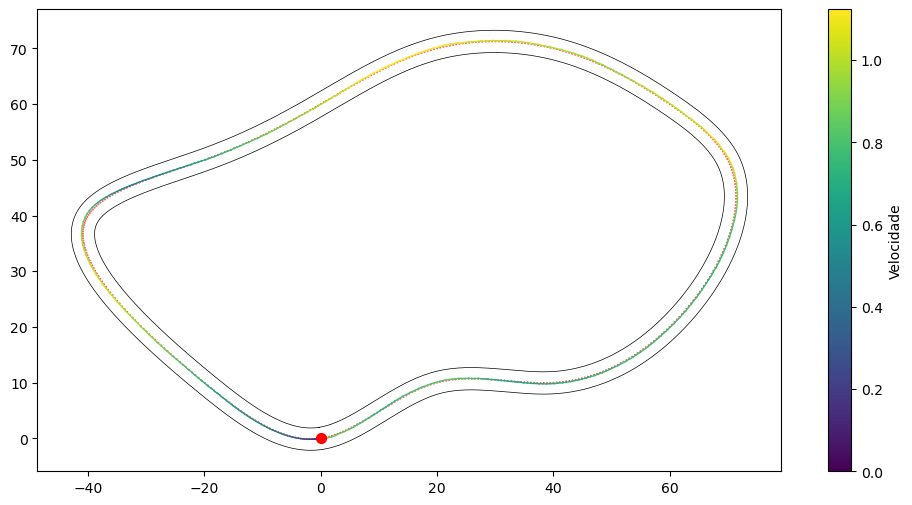

In [158]:
sim = Simulation(TrackBuilder.get_track(), [FuzzyCar(), FuzzyCar(acc_inc=0.005)])
sim.compute_paths()
sim.plot_race()

Métricas carro 0


,MAE,MSE,Desvio Padrão,Variância
0,0.2109,0.0133,0.1945,0.0378


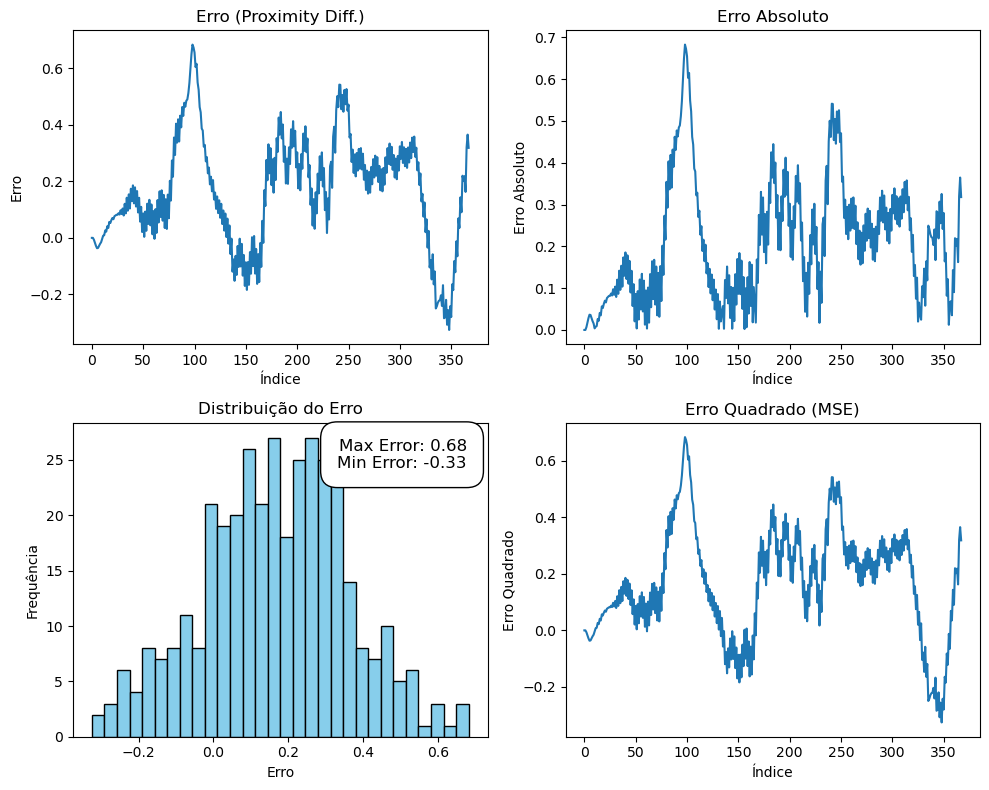

Métricas carro 1


,MAE,MSE,Desvio Padrão,Variância
0,0.1301,0.0074,0.1381,0.0191


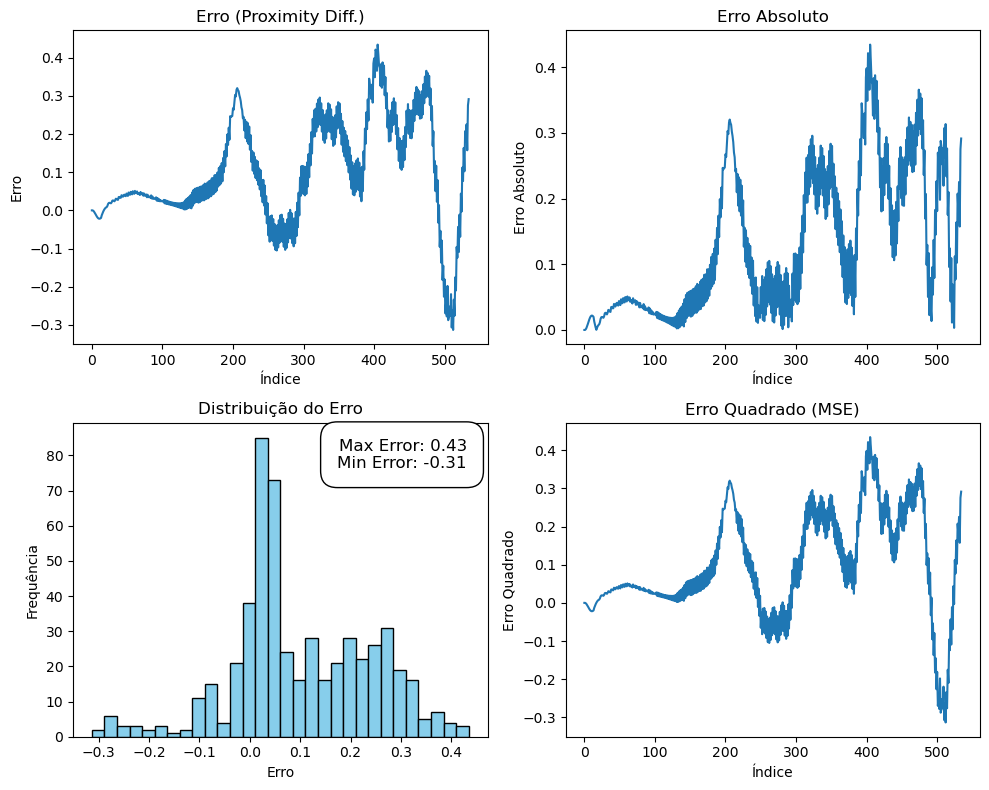

In [ ]:
sim.show_metrics()
